# Korrelationsanalyse - Gemeindemerkmale (Features)

Analyse der Korrelationen zwischen den kontinuierlichen Gemeindemerkmalen aus BFS Regionalportraets und ESTV Einkommensdaten.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths
DB_PATH = Path('../../data/processed/swiss_votings.db')
OUTPUT_DIR = Path('.')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['font.size'] = 9

In [2]:
# Load features data
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query("""
    SELECT * FROM municipality_features_complete
""", conn)

print(f"Geladene Gemeinden: {len(df):,}")
print(f"Anzahl Features: {len(df.columns) - 2}")
print("\nVerfuegbare Features:")
for col in df.columns:
    if col not in ['bfs_nr', 'gemeindename']:
        print(f"  - {col}")

Geladene Gemeinden: 2,187
Anzahl Features: 30

Verfuegbare Features:
  - anteil_0_19_jahre
  - anteil_20_64_jahre
  - anteil_65_plus_jahre
  - auslaenderanteil
  - bevoelkerungsdichte
  - einwohner
  - geburtenziffer
  - haushaltsgroesse
  - heiratsziffer
  - landwirtschaftsflaeche_pct
  - privathaushalte
  - scheidungsziffer
  - siedlungsflaeche_pct
  - sozialhilfequote
  - sterbeziffer
  - unproduktive_flaeche_pct
  - waehleranteil_andere
  - waehleranteil_bdp
  - waehleranteil_cvp
  - waehleranteil_evp_csp
  - waehleranteil_fdp
  - waehleranteil_glp
  - waehleranteil_gps
  - waehleranteil_klein
  - waehleranteil_sp
  - waehleranteil_svp
  - wald_pct
  - steuerbares_einkommen_pro_kopf
  - pct_einkommen_ueber_100k
  - pct_einkommen_unter_40k


## 1. Auswahl relevanter Features fuer Korrelationsanalyse

In [3]:
# Select key features (exclude party vote shares for now - separate analysis)
demographic_features = [
    'einwohner', 'bevoelkerungsdichte', 'auslaenderanteil',
    'anteil_0_19_jahre', 'anteil_20_64_jahre', 'anteil_65_plus_jahre',
    'haushaltsgroesse', 'geburtenziffer', 'sterbeziffer'
]

economic_features = [
    'steuerbares_einkommen_pro_kopf', 'pct_einkommen_ueber_100k', 
    'pct_einkommen_unter_40k', 'sozialhilfequote'
]

spatial_features = [
    'siedlungsflaeche_pct', 'landwirtschaftsflaeche_pct', 
    'wald_pct', 'unproduktive_flaeche_pct'
]

party_features = [
    'waehleranteil_svp', 'waehleranteil_sp', 'waehleranteil_fdp',
    'waehleranteil_cvp', 'waehleranteil_gps', 'waehleranteil_glp'
]

all_features = demographic_features + economic_features + spatial_features + party_features

# Filter to available columns
available_features = [f for f in all_features if f in df.columns]
print(f"Verfuegbare Features fuer Analyse: {len(available_features)}")

Verfuegbare Features fuer Analyse: 23


## 2. Vollstaendige Korrelationsmatrix

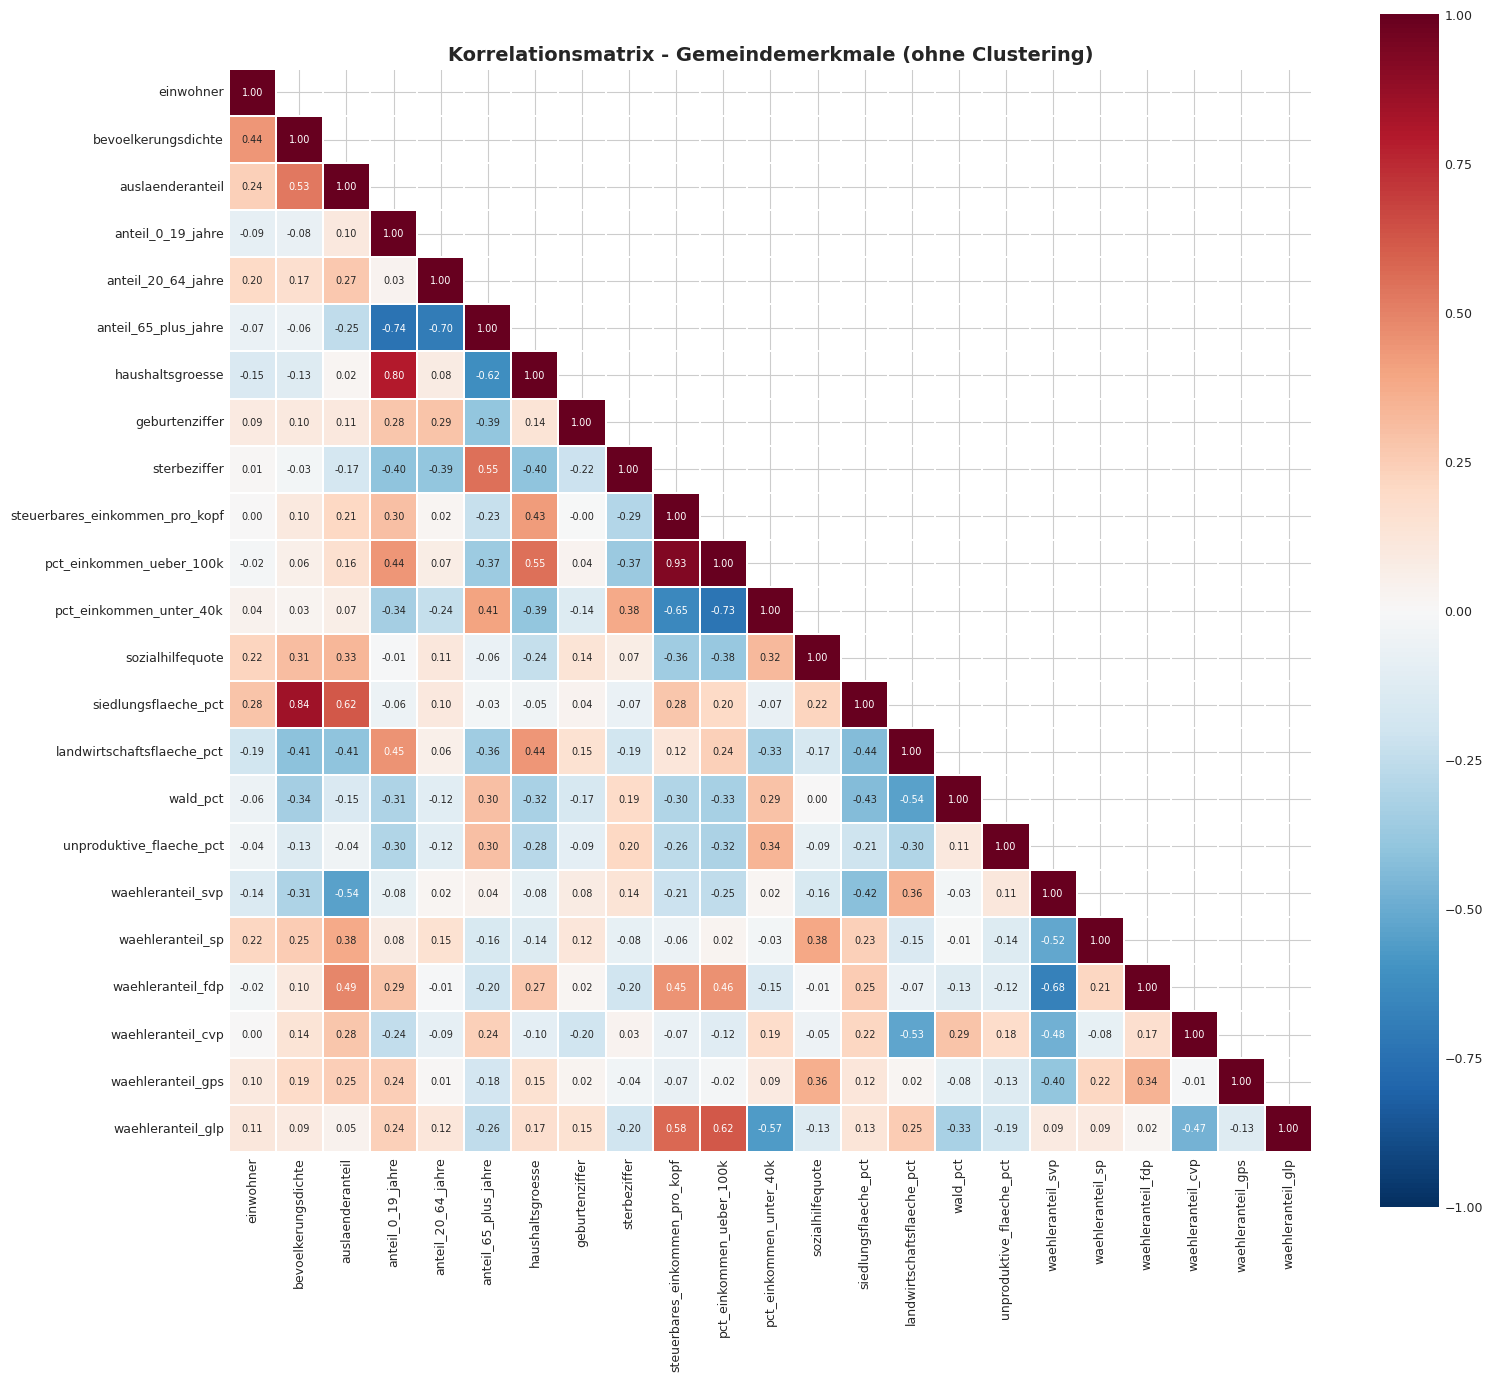


CLUSTERMAP - Hierarchisches Clustering der Features
Aehnliche Variablen werden automatisch zusammengruppiert.


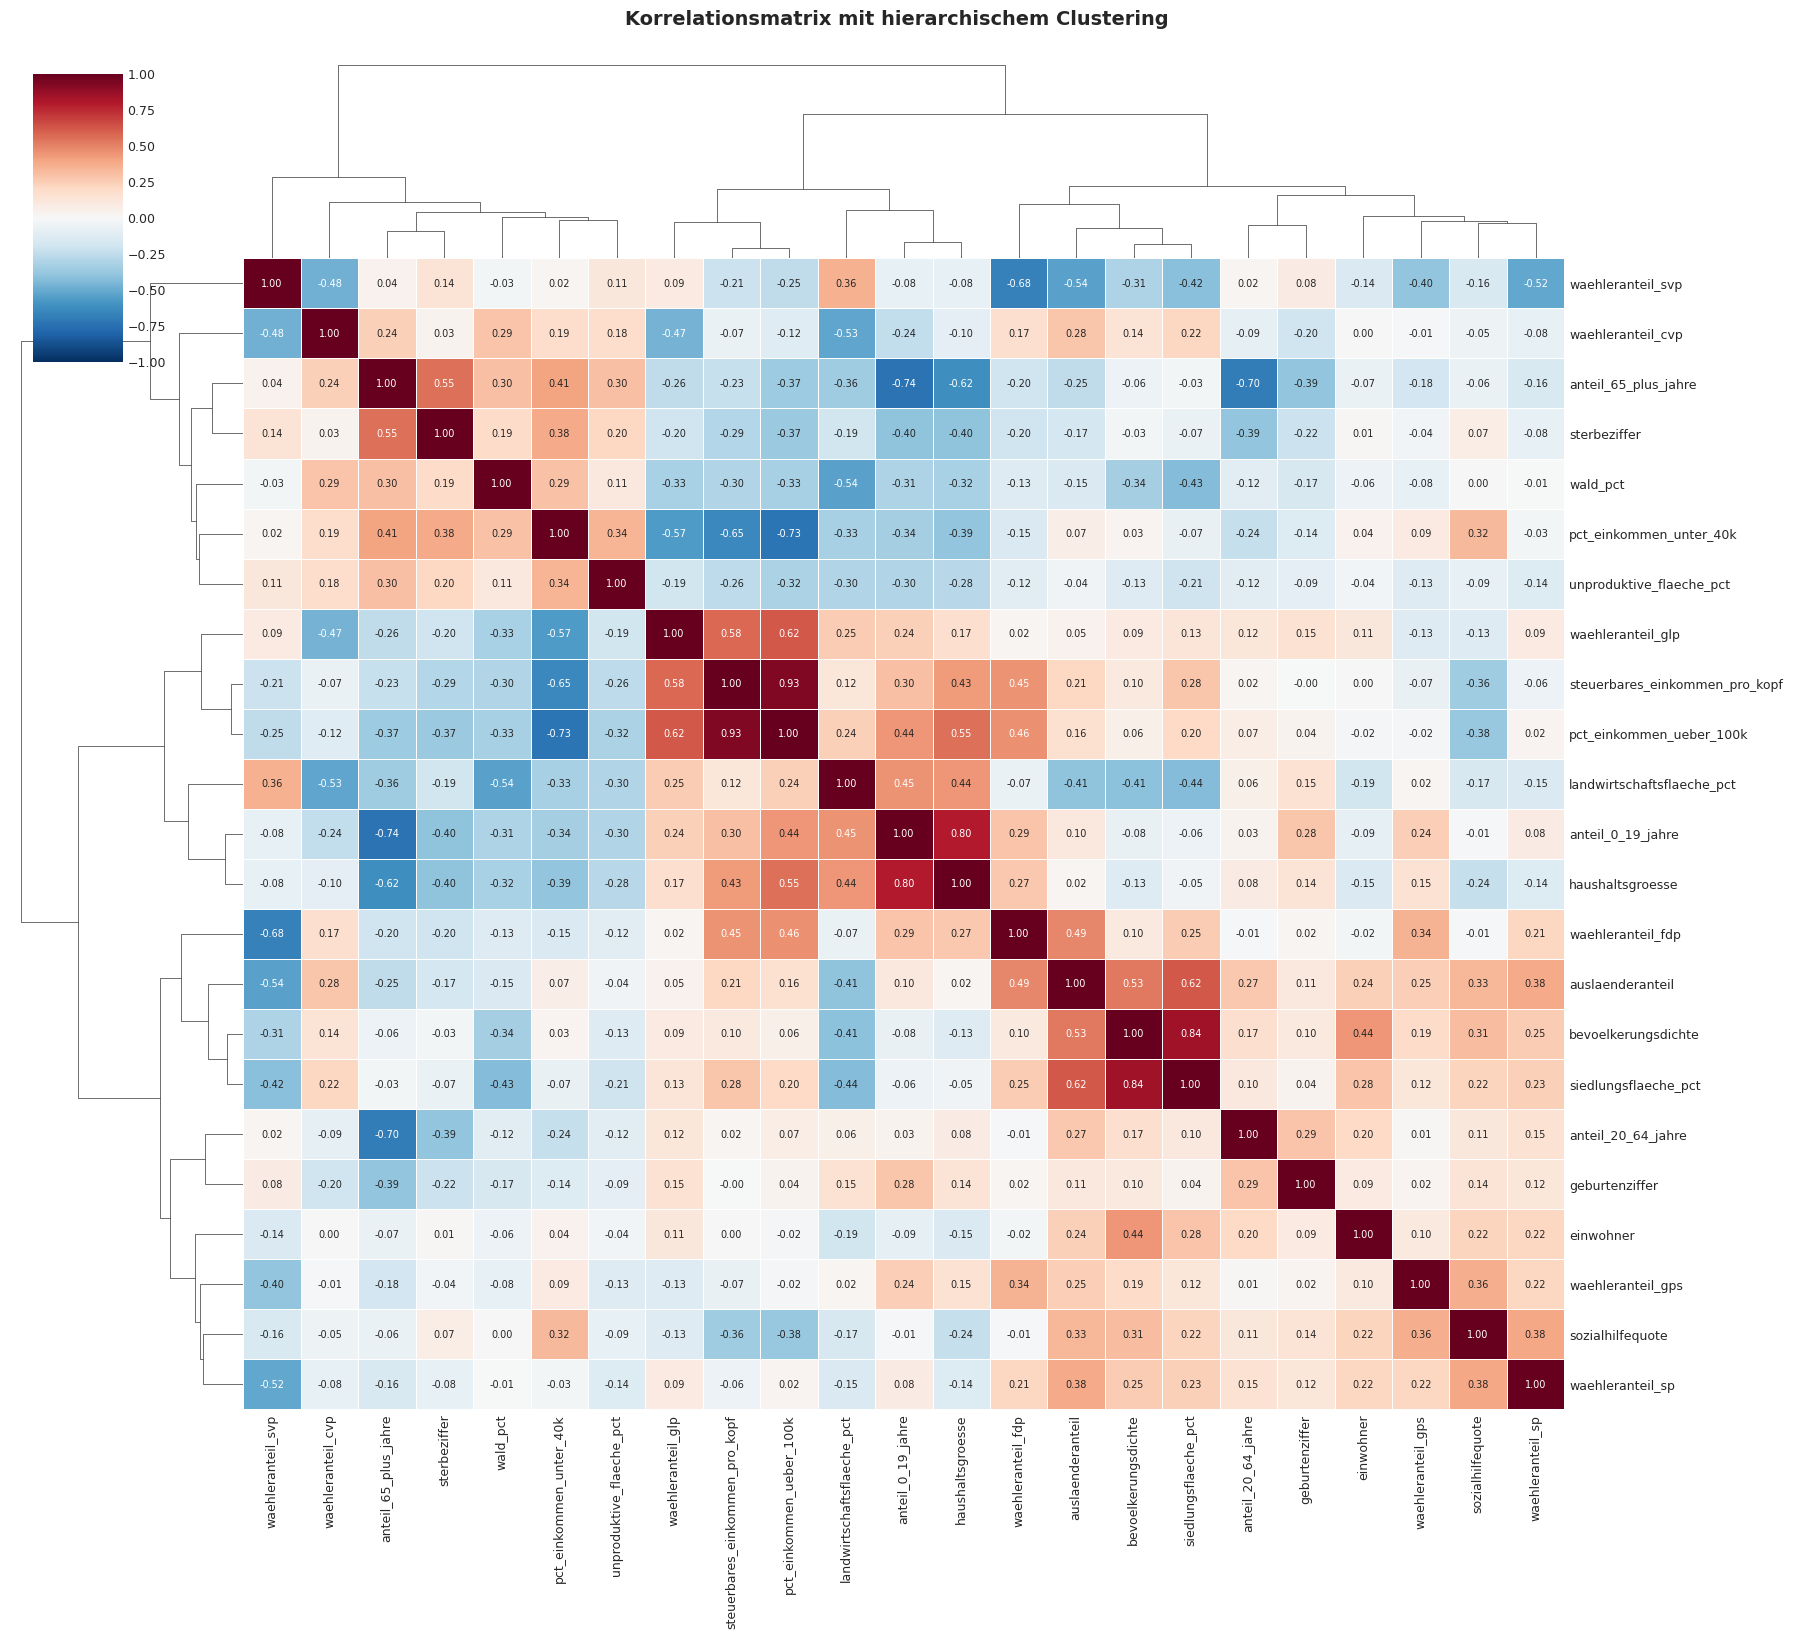


Feature-Reihenfolge nach Clustering:
   1. waehleranteil_svp
   2. waehleranteil_cvp
   3. anteil_65_plus_jahre
   4. sterbeziffer
   5. wald_pct
   6. pct_einkommen_unter_40k
   7. unproduktive_flaeche_pct
   8. waehleranteil_glp
   9. steuerbares_einkommen_pro_kopf
  10. pct_einkommen_ueber_100k
  11. landwirtschaftsflaeche_pct
  12. anteil_0_19_jahre
  13. haushaltsgroesse
  14. waehleranteil_fdp
  15. auslaenderanteil
  16. bevoelkerungsdichte
  17. siedlungsflaeche_pct
  18. anteil_20_64_jahre
  19. geburtenziffer
  20. einwohner
  21. waehleranteil_gps
  22. sozialhilfequote
  23. waehleranteil_sp

Gespeichert: correlation_features_full.png, correlation_features_clustered.png


In [4]:
# Calculate correlation matrix
df_features = df[available_features].dropna()
corr_matrix = df_features.corr()

# 1. Einfache Heatmap (ohne Clustering)
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.3,
            annot_kws={'size': 7},
            ax=ax)
ax.set_title('Korrelationsmatrix - Gemeindemerkmale (ohne Clustering)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_features_full.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. Clustermap - Hierarchisches Clustering gruppiert aehnliche Variablen
print("\n" + "="*70)
print("CLUSTERMAP - Hierarchisches Clustering der Features")
print("="*70)
print("Aehnliche Variablen werden automatisch zusammengruppiert.")

g = sns.clustermap(corr_matrix,
                   method='ward',           # Ward-Methode fuer Clustering
                   metric='euclidean',      # Euklidische Distanz
                   cmap='RdBu_r',
                   center=0,
                   vmin=-1, vmax=1,
                   annot=True,
                   fmt='.2f',
                   annot_kws={'size': 7},
                   figsize=(18, 16),
                   dendrogram_ratio=(0.15, 0.15),
                   linewidths=0.5)

g.fig.suptitle('Korrelationsmatrix mit hierarchischem Clustering', 
               fontsize=14, fontweight='bold', y=1.02)
plt.savefig(OUTPUT_DIR / 'correlation_features_clustered.png', dpi=150, bbox_inches='tight')
plt.show()

# Zeige die Cluster-Reihenfolge
print("\nFeature-Reihenfolge nach Clustering:")
clustered_features = [corr_matrix.columns[i] for i in g.dendrogram_col.reordered_ind]
for i, feat in enumerate(clustered_features, 1):
    print(f"  {i:2d}. {feat}")

print("\nGespeichert: correlation_features_full.png, correlation_features_clustered.png")

## 3. Staerkste Korrelationen

In [5]:
# Extract top correlations
def get_correlation_pairs(corr_df, threshold=0.5):
    """Extract significant correlation pairs."""
    pairs = []
    for i in range(len(corr_df.columns)):
        for j in range(i+1, len(corr_df.columns)):
            col1, col2 = corr_df.columns[i], corr_df.columns[j]
            corr = corr_df.iloc[i, j]
            if abs(corr) >= threshold:
                pairs.append({
                    'Feature 1': col1, 
                    'Feature 2': col2, 
                    'Korrelation': corr,
                    'Interpretation': 'positiv' if corr > 0 else 'negativ'
                })
    
    df_pairs = pd.DataFrame(pairs)
    df_pairs['abs_corr'] = df_pairs['Korrelation'].abs()
    df_pairs = df_pairs.sort_values('abs_corr', ascending=False).drop('abs_corr', axis=1)
    return df_pairs

strong_corrs = get_correlation_pairs(corr_matrix, threshold=0.5)
print(f"Korrelationen mit |r| >= 0.5: {len(strong_corrs)}")
print("\nStaerkste Korrelationen:")
strong_corrs.head(20)

Korrelationen mit |r| >= 0.5: 20

Staerkste Korrelationen:


,Feature 1,Feature 2,Korrelation,Interpretation
10,steuerbares_einkommen_pro_kopf,pct_einkommen_ueber_100k,0.925268,positiv
1,bevoelkerungsdichte,siedlungsflaeche_pct,0.844093,positiv
5,anteil_0_19_jahre,haushaltsgroesse,0.795141,positiv
4,anteil_0_19_jahre,anteil_65_plus_jahre,-0.740453,negativ
13,pct_einkommen_ueber_100k,pct_einkommen_unter_40k,-0.732617,negativ
6,anteil_20_64_jahre,anteil_65_plus_jahre,-0.696511,negativ
19,waehleranteil_svp,waehleranteil_fdp,-0.676240,negativ
11,steuerbares_einkommen_pro_kopf,pct_einkommen_unter_40k,-0.646574,negativ
7,anteil_65_plus_jahre,haushaltsgroesse,-0.623694,negativ
2,auslaenderanteil,siedlungsflaeche_pct,0.619030,positiv


## 4. Korrelationen nach Kategorien

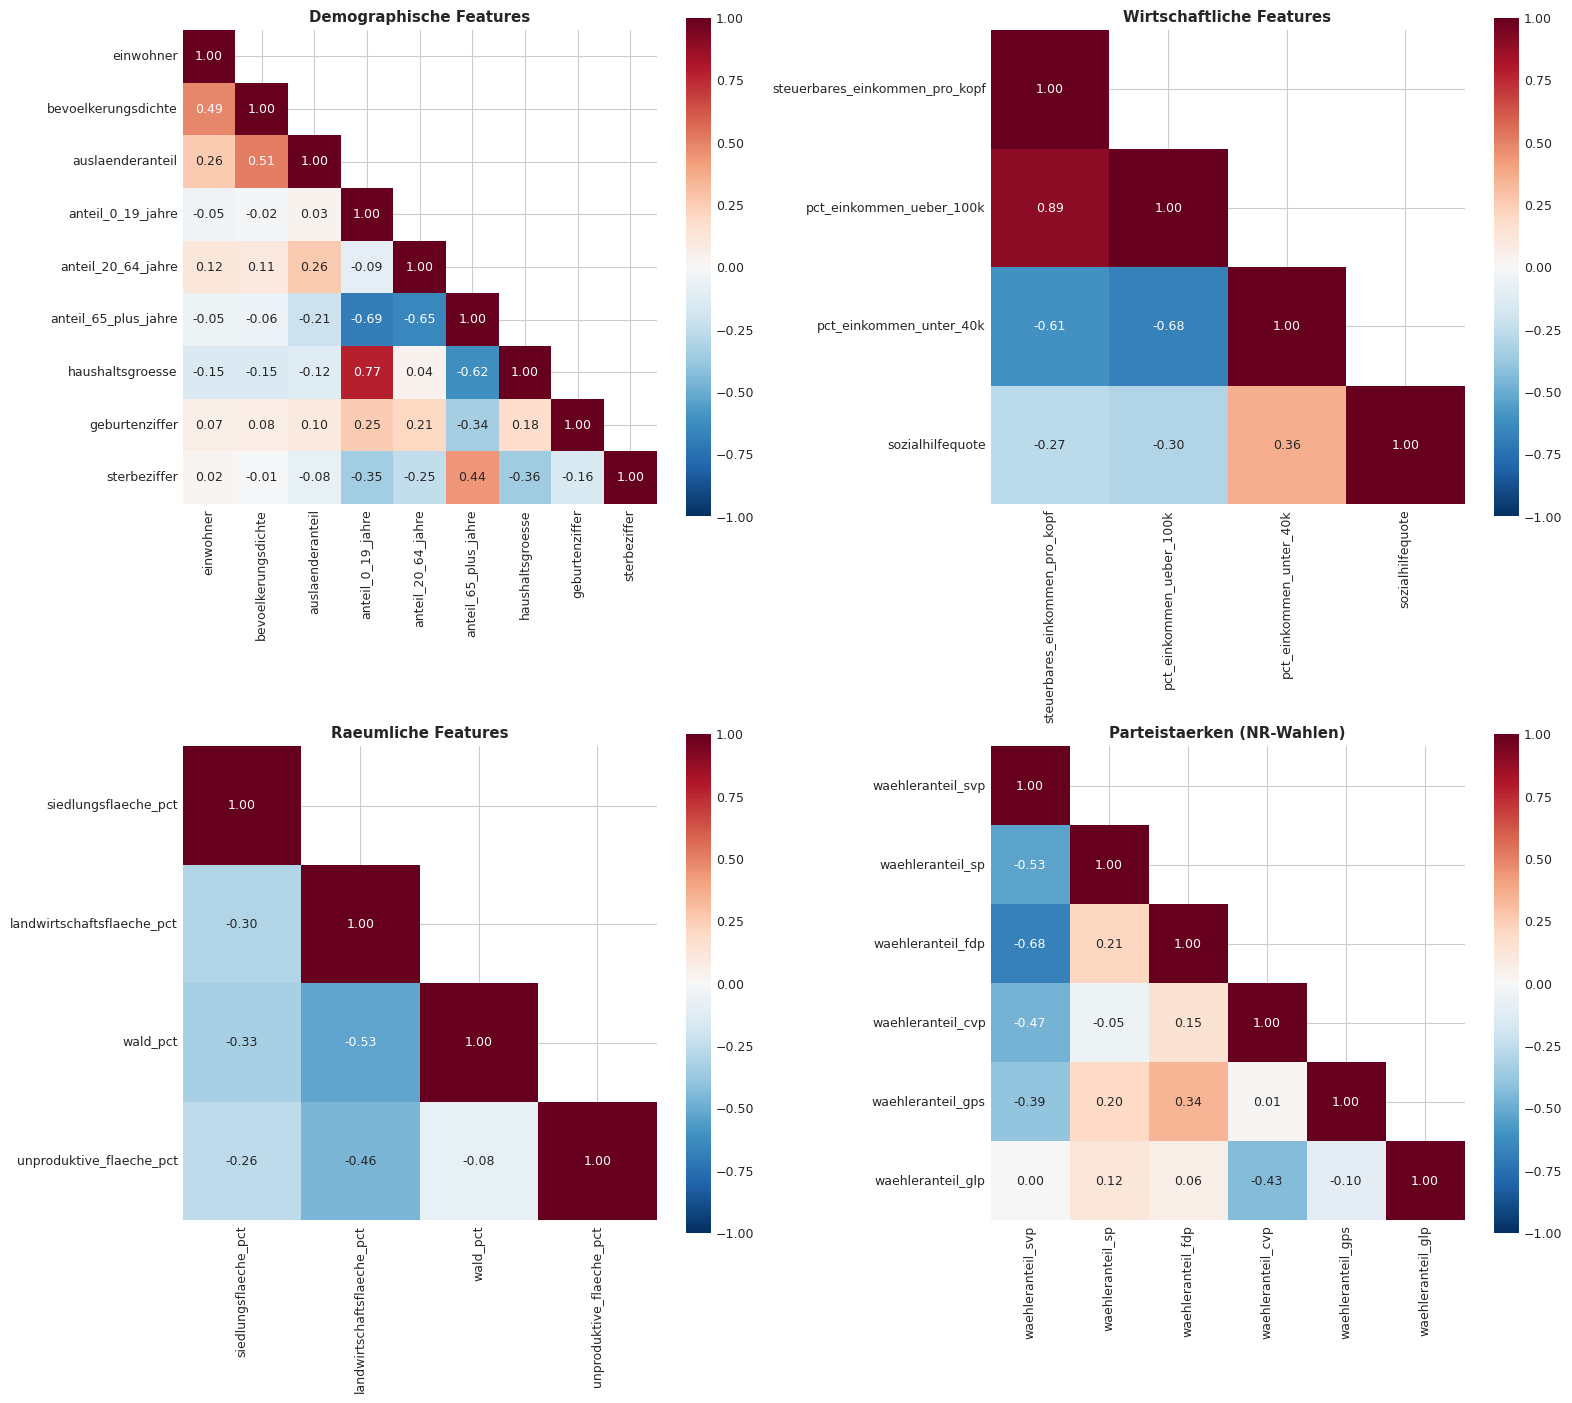

In [6]:
# Demographic features correlation
demo_available = [f for f in demographic_features if f in df.columns]
corr_demo = df[demo_available].dropna().corr()

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Demographics
mask1 = np.triu(np.ones_like(corr_demo, dtype=bool), k=1)
sns.heatmap(corr_demo, mask=mask1, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[0,0], square=True, vmin=-1, vmax=1)
axes[0,0].set_title('Demographische Features', fontweight='bold')

# Economic
econ_available = [f for f in economic_features if f in df.columns]
corr_econ = df[econ_available].dropna().corr()
mask2 = np.triu(np.ones_like(corr_econ, dtype=bool), k=1)
sns.heatmap(corr_econ, mask=mask2, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[0,1], square=True, vmin=-1, vmax=1)
axes[0,1].set_title('Wirtschaftliche Features', fontweight='bold')

# Spatial
spatial_available = [f for f in spatial_features if f in df.columns]
corr_spatial = df[spatial_available].dropna().corr()
mask3 = np.triu(np.ones_like(corr_spatial, dtype=bool), k=1)
sns.heatmap(corr_spatial, mask=mask3, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[1,0], square=True, vmin=-1, vmax=1)
axes[1,0].set_title('Raeumliche Features', fontweight='bold')

# Political
party_available = [f for f in party_features if f in df.columns]
corr_party = df[party_available].dropna().corr()
mask4 = np.triu(np.ones_like(corr_party, dtype=bool), k=1)
sns.heatmap(corr_party, mask=mask4, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[1,1], square=True, vmin=-1, vmax=1)
axes[1,1].set_title('Parteistaerken (NR-Wahlen)', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_features_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Scatter Plots - Interessante Zusammenhaenge

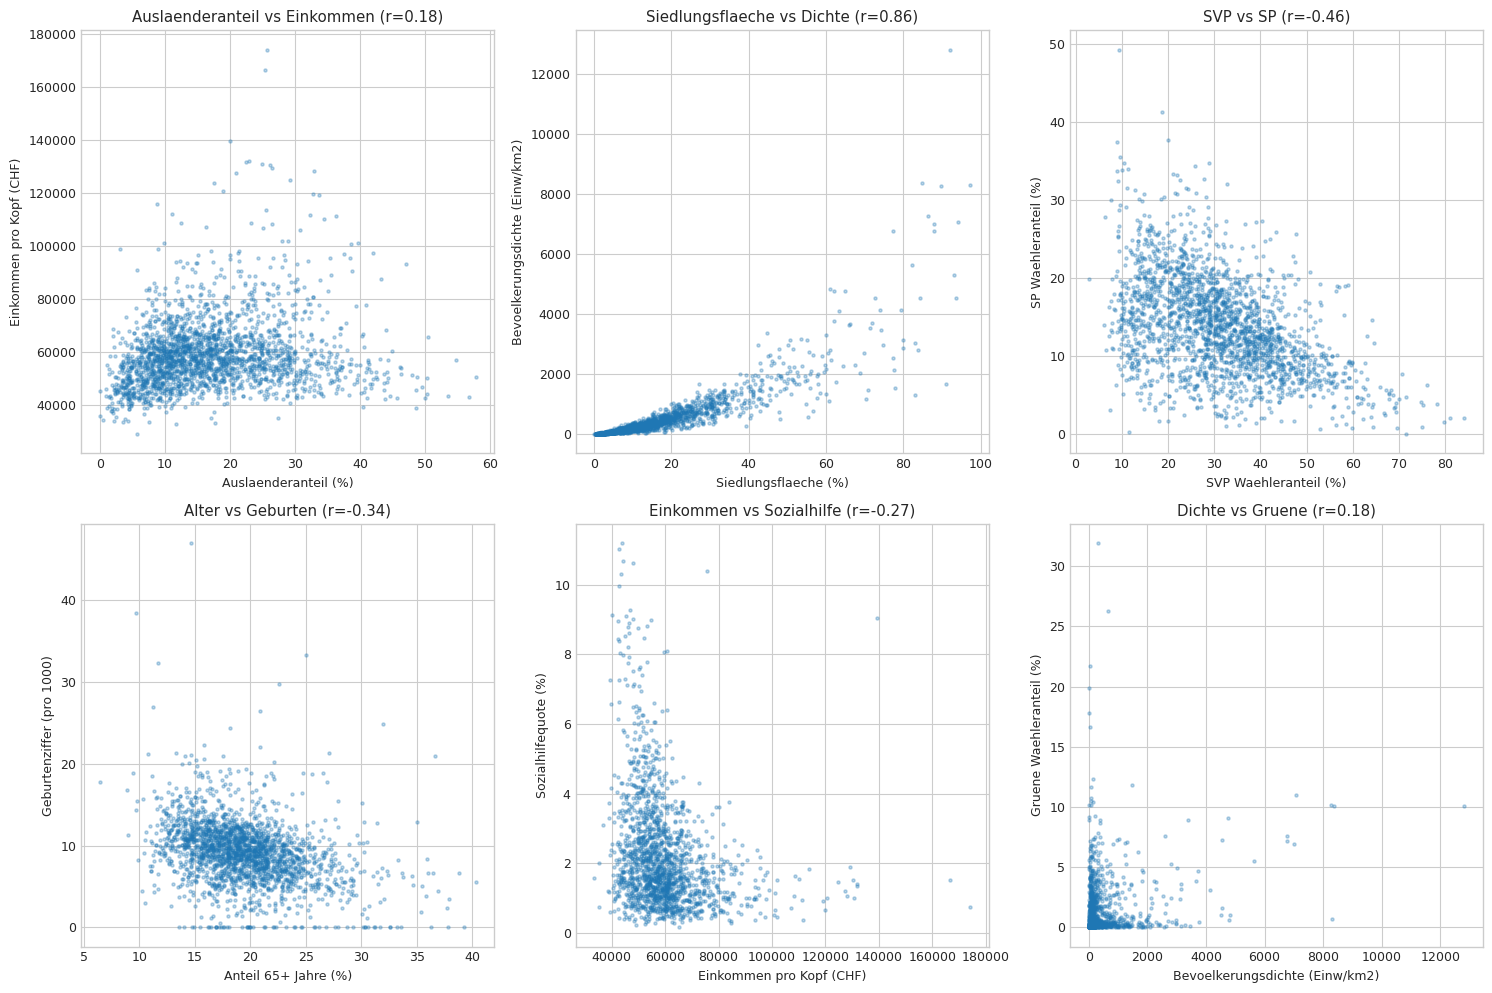

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Einkommen vs Auslaenderanteil
axes[0,0].scatter(df['auslaenderanteil'], df['steuerbares_einkommen_pro_kopf'], alpha=0.3, s=5)
axes[0,0].set_xlabel('Auslaenderanteil (%)')
axes[0,0].set_ylabel('Einkommen pro Kopf (CHF)')
r = df['auslaenderanteil'].corr(df['steuerbares_einkommen_pro_kopf'])
axes[0,0].set_title(f'Auslaenderanteil vs Einkommen (r={r:.2f})')

# 2. Bevoelkerungsdichte vs Siedlungsflaeche
axes[0,1].scatter(df['siedlungsflaeche_pct'], df['bevoelkerungsdichte'], alpha=0.3, s=5)
axes[0,1].set_xlabel('Siedlungsflaeche (%)')
axes[0,1].set_ylabel('Bevoelkerungsdichte (Einw/km2)')
r = df['siedlungsflaeche_pct'].corr(df['bevoelkerungsdichte'])
axes[0,1].set_title(f'Siedlungsflaeche vs Dichte (r={r:.2f})')

# 3. SVP vs SP Waehleranteil
axes[0,2].scatter(df['waehleranteil_svp'], df['waehleranteil_sp'], alpha=0.3, s=5)
axes[0,2].set_xlabel('SVP Waehleranteil (%)')
axes[0,2].set_ylabel('SP Waehleranteil (%)')
r = df['waehleranteil_svp'].corr(df['waehleranteil_sp'])
axes[0,2].set_title(f'SVP vs SP (r={r:.2f})')

# 4. Alter 65+ vs Geburtenziffer
axes[1,0].scatter(df['anteil_65_plus_jahre'], df['geburtenziffer'], alpha=0.3, s=5)
axes[1,0].set_xlabel('Anteil 65+ Jahre (%)')
axes[1,0].set_ylabel('Geburtenziffer (pro 1000)')
r = df['anteil_65_plus_jahre'].corr(df['geburtenziffer'])
axes[1,0].set_title(f'Alter vs Geburten (r={r:.2f})')

# 5. Sozialhilfe vs Einkommen
axes[1,1].scatter(df['steuerbares_einkommen_pro_kopf'], df['sozialhilfequote'], alpha=0.3, s=5)
axes[1,1].set_xlabel('Einkommen pro Kopf (CHF)')
axes[1,1].set_ylabel('Sozialhilfequote (%)')
r = df['steuerbares_einkommen_pro_kopf'].corr(df['sozialhilfequote'])
axes[1,1].set_title(f'Einkommen vs Sozialhilfe (r={r:.2f})')

# 6. Gruene vs Bevoelkerungsdichte
axes[1,2].scatter(df['bevoelkerungsdichte'], df['waehleranteil_gps'], alpha=0.3, s=5)
axes[1,2].set_xlabel('Bevoelkerungsdichte (Einw/km2)')
axes[1,2].set_ylabel('Gruene Waehleranteil (%)')
r = df['bevoelkerungsdichte'].corr(df['waehleranteil_gps'])
axes[1,2].set_title(f'Dichte vs Gruene (r={r:.2f})')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'scatter_features_relationships.png', dpi=150)
plt.show()

## 6. Zusammenfassung

In [8]:
print("="*70)
print("ZUSAMMENFASSUNG - FEATURE-KORRELATIONEN")
print("="*70)
print("\n1. SEHR STARKE KORRELATIONEN (|r| > 0.7):")
very_strong = strong_corrs[strong_corrs['Korrelation'].abs() > 0.7]
for _, row in very_strong.iterrows():
    print(f"   - {row['Feature 1']} <-> {row['Feature 2']}: r={row['Korrelation']:.2f}")

print("\n2. ERWARTETE ZUSAMMENHAENGE:")
print("   - Altersgruppen sind komplementaer (summieren zu 100%)")
print("   - Flaechennutzung korreliert negativ (begrenzte Flaeche)")
print("   - Bevoelkerungsdichte korreliert mit Urbanitaet")

print("\n3. INTERESSANTE BEFUNDE:")
print("   - SVP und SP zeigen negative Korrelation (politische Pole)")
print("   - Gruene korrelieren mit Bevoelkerungsdichte (Staedtisch)")
print("   - Einkommen korreliert positiv mit Auslaenderanteil")

print("\n4. MULTIKOLLINEARITAET:")
print("   Fuer Regression zu beachten:")
n_high = len(strong_corrs[strong_corrs['Korrelation'].abs() > 0.7])
print(f"   - {n_high} Feature-Paare mit |r| > 0.7")
print("   - Altersgruppen nicht gemeinsam verwenden")
print("   - VIF-Pruefung empfohlen")
print("="*70)

# Save correlations
strong_corrs.to_csv(OUTPUT_DIR / 'feature_correlations_strong.csv', index=False)
corr_matrix.to_csv(OUTPUT_DIR / 'feature_correlation_matrix.csv')
print("\nGespeichert: feature_correlations_strong.csv, feature_correlation_matrix.csv")

conn.close()

ZUSAMMENFASSUNG - FEATURE-KORRELATIONEN

1. SEHR STARKE KORRELATIONEN (|r| > 0.7):
   - steuerbares_einkommen_pro_kopf <-> pct_einkommen_ueber_100k: r=0.93
   - bevoelkerungsdichte <-> siedlungsflaeche_pct: r=0.84
   - anteil_0_19_jahre <-> haushaltsgroesse: r=0.80
   - anteil_0_19_jahre <-> anteil_65_plus_jahre: r=-0.74
   - pct_einkommen_ueber_100k <-> pct_einkommen_unter_40k: r=-0.73

2. ERWARTETE ZUSAMMENHAENGE:
   - Altersgruppen sind komplementaer (summieren zu 100%)
   - Flaechennutzung korreliert negativ (begrenzte Flaeche)
   - Bevoelkerungsdichte korreliert mit Urbanitaet

3. INTERESSANTE BEFUNDE:
   - SVP und SP zeigen negative Korrelation (politische Pole)
   - Gruene korrelieren mit Bevoelkerungsdichte (Staedtisch)
   - Einkommen korreliert positiv mit Auslaenderanteil

4. MULTIKOLLINEARITAET:
   Fuer Regression zu beachten:
   - 5 Feature-Paare mit |r| > 0.7
   - Altersgruppen nicht gemeinsam verwenden
   - VIF-Pruefung empfohlen

Gespeichert: feature_correlations_strong.